#### Import Packages

In [214]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline,FeatureUnion
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


### Start collecting 2020 data

This first chunk collects the fanatasy points for the top running backs starting with 2017

Credit to Steven Morse for the framework to get this started
https://stmorse.github.io/journal/pfr-scrape-python.html

In [215]:
url = 'https://www.pro-football-reference.com'
#year = 2019
#maxp = 20

def fant_function(maxp, year):

    url = 'https://www.pro-football-reference.com'

    # grab fantasy players
    r = requests.get(url + '/years/' + str(year) + '/fantasy.htm')
    soup = BeautifulSoup(r.content, 'html.parser')
    parsed_table = soup.find_all('table')[0]  

    df_fpts = []
    tdf = []

    # first 2 rows are col headers
    for i,row in enumerate(parsed_table.find_all('tr')[2:]):
        if i % 10 == 0: print(i, end=' ')
        if i >= maxp: 
            print('\nComplete.')
            break

        try:
            dat = row.find('td', attrs={'data-stat': 'player'})
            name = dat.a.get_text()
            stub = dat.a.get('href')
            stub = stub[:-4] + '/fantasy/' + str(year)
            pos = row.find('td', attrs={'data-stat': 'fantasy_pos'}).get_text()
            if pos != "RB":
                continue

            # grab this players stats
            tdf = pd.read_html(url + stub)[0]    

            # get rid of MultiIndex, just keep last row
            tdf.columns = tdf.columns.get_level_values(-1)

            # fix the away/home column
            tdf = tdf.rename(columns={'Unnamed: 4_level_2': 'Away'})
            tdf['Away'] = [1 if r=='@' else 0 for r in tdf['Away']]

            # drop all intermediate stats
            tdf = tdf.iloc[:,[1,2,3,4,5,-2]]

            # drop "Total" row
            tdf = tdf.query('Date != "Total"')

            # add other info
            tdf['Name'] = name
            tdf['Position'] = pos
            tdf['Season'] = year

            df_fpts.append(tdf)
        except:
            pass
        
    return df_fpts

fp_2019 = pd.concat(fant_function(180,2019))
fp_2020 = pd.concat(fant_function(180,2020))
fp_2018 = pd.concat(fant_function(180,2018))
fp_2017 = pd.concat(fant_function(180,2017))

0 

<ipython-input-215-a21949ccbaf4>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['Name'] = name
<ipython-input-215-a21949ccbaf4>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['Position'] = pos
<ipython-input-215-a21949ccbaf4>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 
Complete.
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 
Complete.
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 
Complete.
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 
Complete.


Collect the gamelogs for the same running backs. 

In [216]:
#Get rid of running backs that are primarily receivers/returners
url = 'https://www.pro-football-reference.com'
#year = 2019
#maxp = 20
    
# grab fantasy players  

def game_function(maxp, year):
    df_gamelog = []
    tdf = []
    r = requests.get(url + '/years/' + str(year) + '/fantasy.htm')
    soup = BeautifulSoup(r.content, 'html.parser')
    parsed_table = soup.find_all('table')[0]
# first 2 rows are col headers
    for i,row in enumerate(parsed_table.find_all('tr')[2:]):
        if i % 10 == 0: print(i, end=' ')
        if i >= maxp: 
            print('\nComplete.')
            break

        try:
            dat = row.find('td', attrs={'data-stat': 'player'})
            name = dat.a.get_text()
            stub = dat.a.get('href')
            stub = stub[:-4] + '/gamelog/' + str(year)
            pos = row.find('td', attrs={'data-stat': 'fantasy_pos'}).get_text()
            if pos != "RB":
                continue
            tdf = pd.read_html(url + stub)[0]
            tdf.columns = tdf.columns.get_level_values(-1)
            tdf = tdf.rename(columns={'Unnamed: 6_level_1': 'Away'})
            tdf['Away'] = [1 if r=='@' else 0 for r in tdf['Away']]
            tdf = tdf.iloc[:,[1,2,4,5,6,7,10,11,12,13,14,15,16,17,18,19,20,-5,-6]]
            tdf['Name'] = name
            tdf['Position'] = pos
            tdf['Season'] = year
            cols = []
            count = 1
            for column in tdf.columns:
                if column == 'Yds':
                    cols.append(f'Yds_{count}')
                    count+=1
                    continue
                cols.append(column)
            tdf.columns = cols
            cols = []
            count = 1
            for column in tdf.columns:
                if column == 'TD':
                    cols.append(f'TD_{count}')
                    count+=1
                    continue
                cols.append(column)
            tdf.columns = cols
            tdf = tdf.rename(columns={'Num': 'Snaps', 'Pct': 'Snap_Pct', 'Yds_1': 'Rush_YDS', 'Yds_2': 'Rec_YDS',
                                     'TD_1': 'Rush_TD', 'TD_2': 'Rec_TD'})
            tdf.drop(tdf.tail(1).index,inplace=True)
            if tdf.columns[6] == "Att":
                df_gamelog.append(tdf)
            else:
                continue
        except:
            pass
    return df_gamelog


games_2019 = pd.concat(game_function(180,2019))
games_2020 = pd.concat(game_function(180,2020))
games_2018 = pd.concat(game_function(180,2018))
games_2017 = pd.concat(game_function(180,2017))


#df_2019 = pd.concat(games_2019)
#games.head()

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 
Complete.
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 
Complete.
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 
Complete.
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 
Complete.


### Cleaning

Merge the 2 datasets to get the fantasy points with game logs

In [217]:
all_2020 = pd.merge(games_2020, fp_2020[["Name", "Date","DKPt"]], how='left')
all_2019 = pd.merge(games_2019, fp_2019[["Name", "Date","DKPt"]], how='left')
all_2018 = pd.merge(games_2018, fp_2018[["Name", "Date","DKPt"]], how='left')
all_2017 = pd.merge(games_2017, fp_2017[["Name", "Date","DKPt"]], how='left')

Fill all n/a with 0 (N/A in a column means they did not register a stat in that area for the game)

In [218]:
all_2020 = all_2020.fillna(0)
all_2019 = all_2019.fillna(0)
all_2018 = all_2018.fillna(0)
all_2017 = all_2017.fillna(0)

I will only use the top 51 running backs from this year  and go back and get their stats from the 3 prior years

In [227]:
names_2020 = np.unique(all_2020['Name'])
fil_2019 = all_2019[all_2019['Name'].isin(names_2020)]
fil_2018 = all_2018[all_2018['Name'].isin(names_2020)]
fil_2017 = all_2017[all_2017['Name'].isin(names_2020)]
everything = pd.concat([all_2020, fil_2019, fil_2018, fil_2017], ignore_index=True)

Combine the Las Vegas Raiders and Oakland Raiders

In [228]:
everything['Tm'] = everything['Tm'].apply(lambda x: "LVR" if (x == "OAK") else x)

Save the clean data so we don't have to re-scrape everytime

In [230]:
#everything.to_csv('all_years.csv')

### Feature Engineering

Create a usage variable such that: (rush attempts + targets) / Total Team Snaps

In [232]:
#start = pd.read_csv("all_years.csv")
start = everything

#Need to get percent out of the snap_pct
start['Snap_Pct'] = start['Snap_Pct'].str.rstrip('%').astype('float') / 100.0

#Usage = (rush attempts + targets) / Total Team Snaps 
start['usage'] = (start['Att'] + start['Tgt']) / (start['Snaps'] / start['Snap_Pct'])

Create a binary high usage variable if a player's average usage is more than one standard deviation from the average usage. I use one standard deviation because the data is right skewed.


In [234]:
#Averages for each player
agg = start.groupby('Name').mean().reset_index()

agg['usage'].mean()
#print(start['usage'].mean())

sd_cutoff = (agg['usage'].std()) + agg['usage'].mean()
agg['High_usage'] = agg['usage'].apply(lambda x: 1 if (x > sd_cutoff) else 0)
w_usage = pd.merge(start, agg[["Name", "High_usage"]], how='left')

Create a binary Touchdown percentage varible similar to the usage percentage that measures (on average) how often a player scores vs total usage

Formula: (rec td + rush td) / (rush attempts + targets)


In [235]:
start['Td_Pct'] = (start['Rush_TD'] + start['Rec_TD']) / (start['Att'] + start['Tgt'])

agg_td = start.groupby('Name').mean().reset_index()

agg_td['Td_Pct'].std()

sd_cutoff = (agg_td['Td_Pct'].std()) + agg_td['Td_Pct'].mean()
agg_td['High_Td_pct'] = agg_td['Td_Pct'].apply(lambda x: 1 if (x > sd_cutoff) else 0)

engineered = pd.merge(w_usage, agg_td[["Name", "High_Td_pct"]], how='left')

Create a Boom/Bust feature for highly volatile players that denotes which players have an unusually high variance from week to week (ie 20 points one week and 6 the next) 

In [236]:
grouped_sd = engineered.groupby('Name')['DKPt'].std().reset_index()



sd_cutoff = (grouped_sd['DKPt'].std()) + grouped_sd['DKPt'].mean()
grouped_sd['Boom/Bust'] = grouped_sd['DKPt'].apply(lambda x: 1 if (x > sd_cutoff) else 0)

for_model = pd.merge(engineered, grouped_sd[["Name", "Boom/Bust"]], how='left')

for_model


,Date,G#,Age,Tm,Away,Opp,Att,Rush_YDS,Y/A,Rush_TD,...,Snap_Pct,Snaps,Name,Position,Season,DKPt,usage,High_usage,High_Td_pct,Boom/Bust
0,2020-09-13,1.0,25.034,MIN,0,GNB,12.0,50.0,4.17,2.0,...,0.58,30.0,Dalvin Cook,RB,2020,21.8,0.270667,1,0,1
1,2020-09-20,2.0,25.041,MIN,1,IND,14.0,63.0,4.50,1.0,...,0.80,43.0,Dalvin Cook,RB,2020,17.1,0.297674,1,0,1
2,2020-09-27,3.0,25.048,MIN,0,TEN,22.0,181.0,8.23,1.0,...,0.74,48.0,Dalvin Cook,RB,2020,29.9,0.416250,1,0,1
3,2020-10-04,4.0,25.055,MIN,1,HOU,27.0,130.0,4.81,2.0,...,0.74,49.0,Dalvin Cook,RB,2020,31.6,0.437959,1,0,1
4,2020-10-11,5.0,25.062,MIN,1,SEA,17.0,65.0,3.82,1.0,...,0.41,36.0,Dalvin Cook,RB,2020,19.9,0.250556,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,2017-10-22,7.0,32.215,ARI,1,LAR,11.0,21.0,1.91,0.0,...,0.54,27.0,Adrian Peterson,RB,2017,4.3,0.300000,0,0,0
1604,2017-11-05,8.0,32.229,ARI,1,SFO,37.0,159.0,4.30,0.0,...,0.77,59.0,Adrian Peterson,RB,2017,20.7,0.535085,0,0,0
1605,2017-11-09,9.0,32.233,ARI,0,SEA,21.0,29.0,1.38,0.0,...,0.45,36.0,Adrian Peterson,RB,2017,4.2,0.287500,0,0,0
1606,2017-11-19,10.0,32.243,ARI,1,HOU,14.0,26.0,1.86,0.0,...,0.64,37.0,Adrian Peterson,RB,2017,4.9,0.259459,0,0,0


## EDA

In [237]:
for_model.describe()

,G#,Age,Away,Att,Rush_YDS,Y/A,Rush_TD,Tgt,Rec,Rec_YDS,...,Rec_TD,Y/Tgt,Snap_Pct,Snaps,Season,DKPt,usage,High_usage,High_Td_pct,Boom/Bust
count,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,1608.000000,...,1608.000000,1608.000000,1607.000000,1608.000000,1608.000000,1608.000000,1592.000000,1608.000000,1608.000000,1608.000000
mean,7.712687,24.936527,0.504975,12.212687,54.095149,4.303576,0.429726,3.401119,2.605100,21.435945,...,0.121891,5.535498,0.530896,35.276119,2018.760572,13.910075,0.237701,0.263682,0.151741,0.266169
std,4.330703,3.352527,0.500131,7.008807,39.627124,2.869000,0.687726,2.787459,2.326257,23.582230,...,0.352879,5.465962,0.236035,16.410292,1.096132,10.003503,0.115795,0.440766,0.358882,0.442091
min,1.000000,21.048000,0.000000,0.000000,-4.000000,-3.000000,0.000000,0.000000,0.000000,-7.000000,...,0.000000,-7.000000,0.000000,0.000000,2017.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,23.040000,0.000000,7.000000,23.000000,3.000000,0.000000,1.000000,1.000000,3.000000,...,0.000000,1.500000,0.360000,23.000000,2018.000000,6.100000,0.149931,0.000000,0.000000,0.000000
50%,8.000000,24.148000,1.000000,12.000000,47.000000,4.000000,0.000000,3.000000,2.000000,15.000000,...,0.000000,4.750000,0.540000,35.000000,2019.000000,12.250000,0.237929,0.000000,0.000000,0.000000
75%,11.000000,26.004000,1.000000,17.000000,78.000000,5.242500,1.000000,5.000000,4.000000,31.000000,...,0.000000,7.865000,0.700000,47.000000,2020.000000,19.300000,0.318785,1.000000,0.000000,1.000000
max,16.000000,37.206000,1.000000,37.000000,238.000000,35.000000,4.000000,20.000000,15.000000,159.000000,...,2.000000,55.000000,1.000000,86.000000,2020.000000,55.600000,0.631304,1.000000,1.000000,1.000000


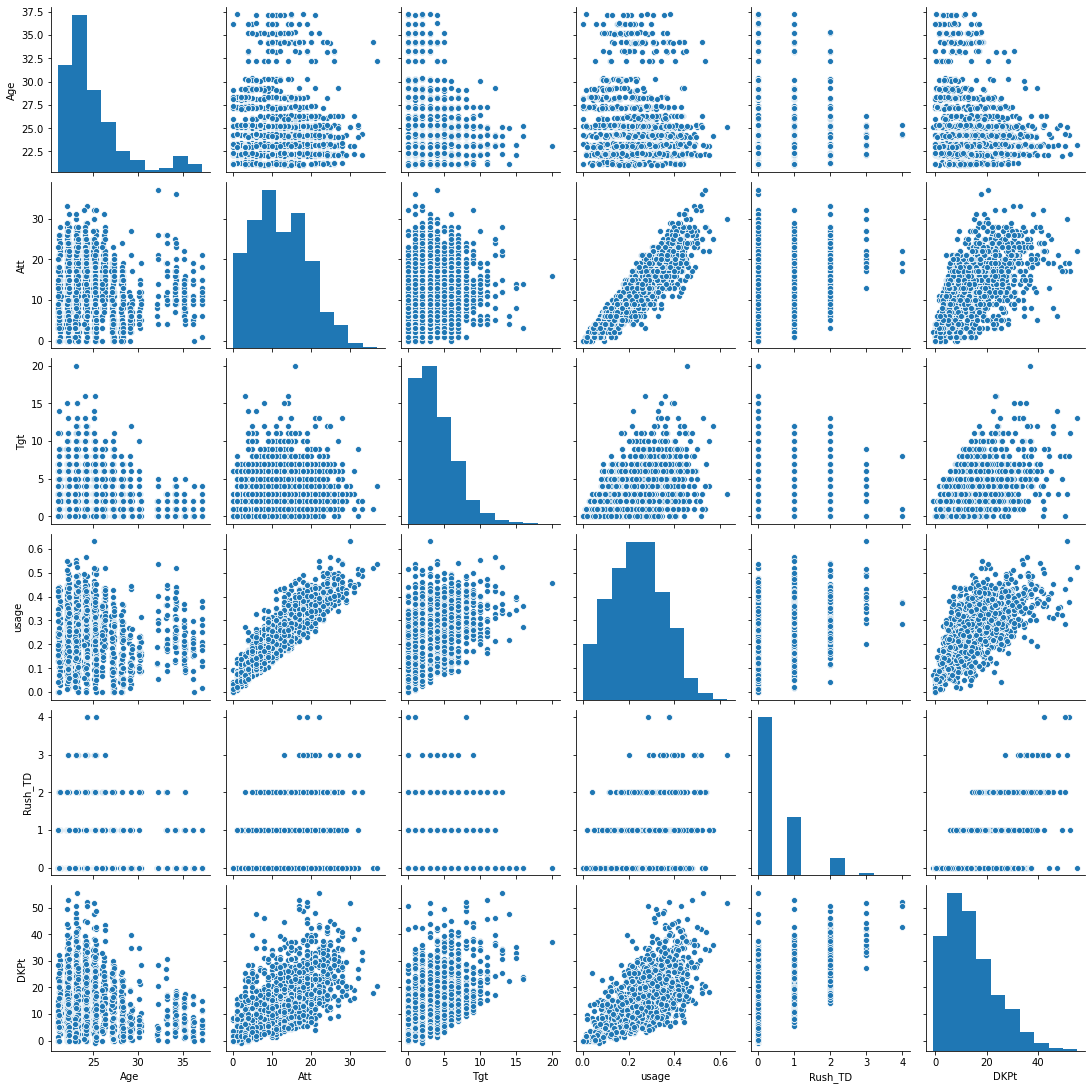

In [238]:
#Pair plots of the data 
print(sns.pairplot(for_model[["Age","Att","Tgt","usage","Rush_TD", "DKPt"]]))

In [239]:
#Teams that allow most/least fantasy points to RBs
print("Most Favorable Matchups")
print(for_model.groupby("Opp")["DKPt"].mean().sort_values(ascending=False).head(10))
print("\n")
print("Least Favorable Matchups")
print(for_model.groupby("Opp")["DKPt"].mean().sort_values().head(10))

Most Favorable Matchups
Opp
NYG    16.271739
GNB    16.023404
JAX    15.922917
CIN    15.759184
DET    15.698214
HOU    15.693878
IND    15.389744
CLE    15.327778
ATL    15.137500
LAC    15.034146
Name: DKPt, dtype: float64


Least Favorable Matchups
Opp
PIT    10.783333
NOR    10.808511
CHI    11.269643
NYJ    11.559184
BAL    12.226000
NWE    12.440426
BUF    12.590385
MIN    12.634043
MIA    12.662000
LAR    12.854386
Name: DKPt, dtype: float64


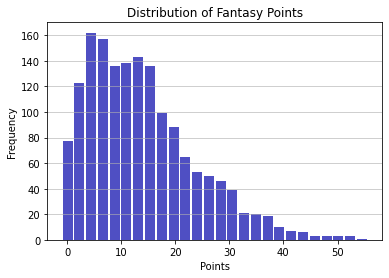

In [240]:
#Histogram of Response
#Shown in pairs plts but important to see
n, bins, patches = plt.hist(x=for_model["DKPt"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.title('Distribution of Fantasy Points')
plt.show()

In [241]:
#Most/Least productive running backs on average
print("Most Productive Players")
print(for_model.groupby("Name")["DKPt"].mean().sort_values(ascending=False).head(10))
print("\n")
print("Least Productive Players")
print(for_model.groupby("Name")["DKPt"].mean().sort_values().head(10))

Most Productive Players
Name
Christian McCaffrey     23.974510
Alvin Kamara            21.471930
Dalvin Cook             21.188889
Todd Gurley             21.163636
Ezekiel Elliott         20.813462
James Robinson          19.733333
Kareem Hunt             18.405128
Melvin Gordon           17.876471
James Conner            17.863636
Chris Carson            16.618919
Name: DKPt, dtype: float64


Least Productive Players
Name
Devontae Booker    6.175000
Cam Akers          6.260000
Joshua Kelley      6.866667
Gus Edwards        7.031579
Boston Scott       7.717391
Frank Gore         7.955172
Zack Moss          8.155556
Malcolm Brown      8.400000
J.K. Dobbins       8.830000
Chase Edmonds      8.864000
Name: DKPt, dtype: float64


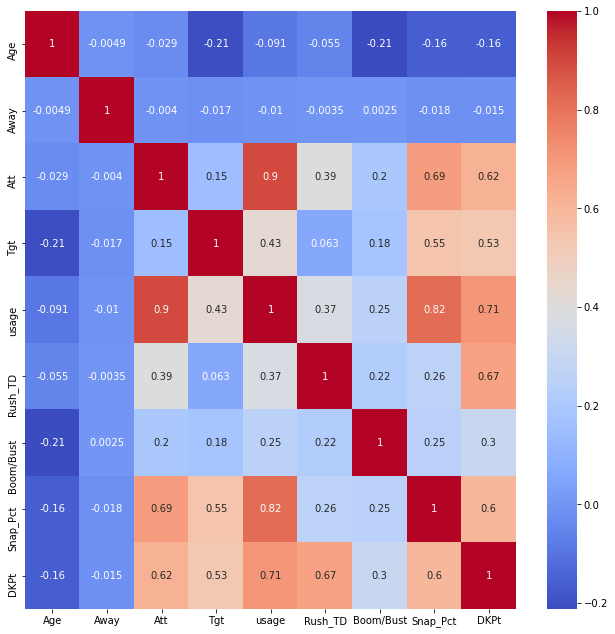

In [242]:
#Heatmap to see correlatation between variables
f, ax = plt.subplots(figsize=(11,11))
sns.heatmap(for_model[["Age", "Away", "Att","Tgt","usage","Rush_TD", "Boom/Bust", "Snap_Pct" ,"DKPt"]].corr(), annot=True, cmap="coolwarm")
plt.show()

## Begin Modeling

In [243]:
#Get only the variables that we want

var_keep = for_model[["Age","Away", "Season", "Tm", "Opp", "High_usage", "High_Td_pct", "Boom/Bust", "DKPt"]]

var_keep['Season'] = var_keep['Season'].astype(object)

X = var_keep.loc[:,'Age':"Boom/Bust"]
y = var_keep.loc[:,'DKPt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=55)


#  Numerical features
numeric_features = X_train.select_dtypes(exclude='object').columns

#  Categorical features
categorical_features = X_train.select_dtypes('object').columns


#Make a pipeline to prep the data 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


<ipython-input-243-f642341117ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_keep['Season'] = var_keep['Season'].astype(object)


#### Lasso Regression

In [244]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  Lasso(alpha=190))])
clf.fit(X_train, y_train)

yhat_train = clf.predict(X_train)
yhat_test = clf.predict(X_test)


#print(yhat_train)
#print(np.sqrt(mean_squared_error(y_train, yhat_train)))
print(np.sqrt(mean_squared_error(y_test, yhat_test)))

scores2 = cross_val_score(clf, X_test, y_test, scoring='neg_root_mean_squared_error')
print(np.mean(scores2)*-1)

9.918273401809053
9.892611241007529


#### KNN Regressor

In [245]:
knn_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('poly',PolynomialFeatures(interaction_only=True)),
                         ('knn', KNeighborsRegressor())])

knn_param_grid = [{'knn__n_neighbors': list(range(1,30)), 'poly__degree':[1,2,3]}]
knn_gs = GridSearchCV(knn_pipeline, knn_param_grid)
knn_gs.fit(X_train, y_train) 
knn_gs.best_estimator_
knn_gs.best_params_

#best model degrees = 1, n_neighbors = 15 

{'knn__n_neighbors': 15, 'poly__degree': 1}

In [247]:
knn_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('poly',PolynomialFeatures(interaction_only=True)),
                         ('knn', KNeighborsRegressor(n_neighbors=15))])
knn_pipeline.fit(X_train, y_train)
yhat_train = knn_pipeline.predict(X_train)
yhat_test = knn_pipeline.predict(X_test)

#print(np.sqrt(mean_squared_error(y_train,yhat_train)))
print(np.sqrt(mean_squared_error(y_test, yhat_test)))

scores2 = cross_val_score(knn_pipeline, X_test, y_test, scoring='neg_root_mean_squared_error')
print(np.mean(scores2)*-1)

9.543246948436396
9.982216690128945


#### Gradient Boost 

In [248]:
from sklearn.ensemble import GradientBoostingRegressor

grad_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('poly',PolynomialFeatures(interaction_only=True)),
                         ('grad', GradientBoostingRegressor())])

grad_param_grid = [{'grad__n_estimators': list(range(300,350)), 'grad__max_depth': list(range(2,4)),
                    'grad__min_samples_split': [0.01,0.1,0.5],
                    'poly__degree':[1]}]
grad_gs = GridSearchCV(grad_pipeline, grad_param_grid)
grad_gs.fit(X_train, y_train) 
grad_gs.best_estimator_
grad_gs.best_params_

{'grad__max_depth': 2,
 'grad__min_samples_split': 0.01,
 'grad__n_estimators': 300,
 'poly__degree': 1}

In [249]:
grad_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('poly',PolynomialFeatures(interaction_only=True)),
                         ('grad', GradientBoostingRegressor(n_estimators = 300, max_depth = 2,
                                                           min_samples_split = 0.01))])

grad_pipeline.fit(X_train, y_train)
yhat_train = grad_pipeline.predict(X_train)
yhat_test = grad_pipeline.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, yhat_test)))

scores2 = cross_val_score(grad_pipeline, X_test, y_test, scoring='neg_root_mean_squared_error')
print(np.mean(scores2)*-1)

9.737151999206413
10.820268563381171


#### Decision Tree

In [250]:
dtr_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('poly', PolynomialFeatures()),
     ('dtr', DecisionTreeRegressor())])
param_grid = [{'dtr__min_samples_leaf': list(range(1,30)), 'poly__degree':[1,2,3]}]
dtr_gs = GridSearchCV(dtr_pipe, param_grid)
dtr_gs.fit(X_train, y_train)
dtr_gs.best_estimator_
dtr_gs.best_params_

{'dtr__min_samples_leaf': 27, 'poly__degree': 2}

In [251]:
dtr_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('poly', PolynomialFeatures(degree = 2)),
     ('dtr', DecisionTreeRegressor(min_samples_leaf=27))])
dtr_pipe.fit(X_train, y_train)
yhat_train = dtr_pipe.predict(X_train)
yhat_test = dtr_pipe.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, yhat_test)))

scores2 = cross_val_score(dtr_pipe, X_test, y_test, scoring='neg_root_mean_squared_error')
print(np.mean(scores2)*-1)

9.698185456343923
9.619930265952416


#### Random Forest Regressor

In [252]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('poly', PolynomialFeatures()),
     ('rf', RandomForestRegressor(n_estimators = 200))])
param_grid = [{'rf__min_samples_leaf': list(range(3,20)), 'poly__degree':[1,2]}]
rf_gs = GridSearchCV(rf_pipe, param_grid)
rf_gs.fit(X_train, y_train)
rf_gs.best_estimator_
rf_gs.best_params_

{'poly__degree': 1, 'rf__min_samples_leaf': 8}

In [255]:
rf_pipe = Pipeline(
    [('preprocessor', preprocessor),
     ('poly', PolynomialFeatures()),
     ('rf', RandomForestRegressor(n_estimators = 500, min_samples_leaf=8))])

rf_pipe.fit(X_train, y_train)
yhat_train = rf_pipe.predict(X_train)
yhat_test = rf_pipe.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, yhat_test)))

scores2 = cross_val_score(rf_pipe, X_test, y_test, scoring='neg_root_mean_squared_error')
print(np.mean(scores2)*-1)

9.526321943043648
9.436539832169146
